<a href="https://colab.research.google.com/github/sladem-tox/Rdkit-stuff/blob/main/Drug_Checker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Let's have a look at drugs!

Take a few smiles structures for common drugs and we will have a look at them together. 

1.   Draw them
2.   Count their features
1.   Check with Chris!!




In [1]:
!pip install rdkit 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 34.7 MB/s eta 0:00:00


In [3]:
smiles_list = ['CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4', 'CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4C5=NNN=N5)C(=O)O', 
               'O=C([C@H](CC1=CNC=N1)N)O', 'C([C@@H](C(=O)O)N)S', 'CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4']

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
mol_list = []
for smiles in smiles_list:
  mol = Chem.MolFromSmiles(smiles)
  mol_list.append(mol)
  img = Draw.MolsToGridImage(mol_list, molsPerRow=4)


## Now let's draw them!

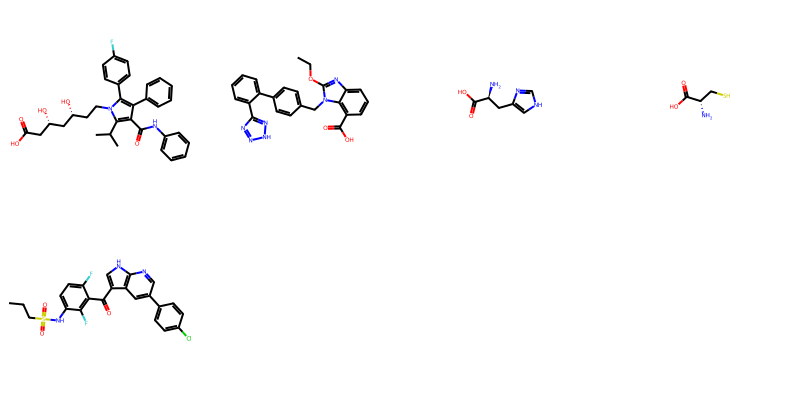

In [6]:
img

## Now let's count their atoms and rings!

In [7]:
from rdkit import Chem

def count_atoms_and_rings(smiles_list):
    results = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)

        num_carbons = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]")))
        num_nitrogens = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#7]")))
        num_oxygens = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#8]")))
        num_halogens = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#9,#17,#35,#53]")))
        num_rings = len(Chem.GetSymmSSSR(mol))

        result = {"smiles": smiles, "Carbons": num_carbons, "Nitrogens": num_nitrogens, 
                  "Oxygens": num_oxygens, "Halogens": num_halogens, "Rings": num_rings}
        results.append(result)
    return results


In [8]:
count_atoms_and_rings(smiles_list)

[{'smiles': 'CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4',
  'Carbons': 33,
  'Nitrogens': 2,
  'Oxygens': 5,
  'Halogens': 1,
  'Rings': 4},
 {'smiles': 'CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4C5=NNN=N5)C(=O)O',
  'Carbons': 24,
  'Nitrogens': 6,
  'Oxygens': 3,
  'Halogens': 0,
  'Rings': 5},
 {'smiles': 'O=C([C@H](CC1=CNC=N1)N)O',
  'Carbons': 6,
  'Nitrogens': 3,
  'Oxygens': 2,
  'Halogens': 0,
  'Rings': 1},
 {'smiles': 'C([C@@H](C(=O)O)N)S',
  'Carbons': 3,
  'Nitrogens': 1,
  'Oxygens': 2,
  'Halogens': 0,
  'Rings': 0},
 {'smiles': 'CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4',
  'Carbons': 23,
  'Nitrogens': 3,
  'Oxygens': 3,
  'Halogens': 3,
  'Rings': 4}]

## Do they pass Lipinski's Rule of Five?

In [9]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def check_lipinski_rule(smiles_list):
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        violations = []
        if Descriptors.MolWt(mol) > 500:
            violations.append('molecular weight > 500')
        if Descriptors.NumHAcceptors(mol) > 10:
            violations.append('number of hydrogen bond acceptors > 10')
        if Descriptors.NumHDonors(mol) > 5:
            violations.append('number of hydrogen bond donors > 5')
        if Descriptors.MolLogP(mol) > 5:
            violations.append('logP > 5')
        if violations:
            print(f"SMILES '{smiles}' fails Lipinski's Rule of Five due to the following reasons: {', '.join(violations)}")
        else:
            print(f"SMILES '{smiles}' passes Lipinski's Rule of Five.")


In [10]:
check_lipinski_rule(smiles_list)

SMILES 'CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4' fails Lipinski's Rule of Five due to the following reasons: molecular weight > 500, logP > 5
SMILES 'CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4C5=NNN=N5)C(=O)O' passes Lipinski's Rule of Five.
SMILES 'O=C([C@H](CC1=CNC=N1)N)O' passes Lipinski's Rule of Five.
SMILES 'C([C@@H](C(=O)O)N)S' passes Lipinski's Rule of Five.
SMILES 'CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4' fails Lipinski's Rule of Five due to the following reasons: logP > 5


by Michal 'Goldmoon' Kwasniewski
                            __...------------._
                         ,-'                   `-.
                      ,-'                         `.
                    ,'                            ,-`.
                   ;                              `-' `.
                  ;                                 .-. \
                 ;                           .-.    `-'  \
                ;                            `-'          \
               ;                                          `.
               ;                                           :
              ;                                            |
             ;                                             ;
            ;                            ___              ;
           ;                        ,-;-','.`.__          |
       _..;                      ,-' ;`,'.`,'.--`.        |
      ///;           ,-'   `. ,-'   ;` ;`,','_.--=:      /
     |'':          ,'        :     ;` ;,;,,-'_.-._`.   ,'
     '  :         ;_.-.      `.    :' ;;;'.ee.    \|  /
      \.'    _..-'/8o. `.     :    :! ' ':8888)   || /
       ||`-''    \\88o\ :     :    :! :  :`""'    ;;/
       ||         \"88o\;     `.    \ `. `.      ;,'
       /)   ___    `."'/(--.._ `.    `.`.  `-..-' ;--.
       \(.="""""==.. `'-'     `.|      `-`-..__.-' `. `.
        |          `"==.__      )                    )  ;
        |   ||           `"=== '                   .'  .'
        /\,,||||  | |           \                .'   .'
        | |||'|' |'|'           \|             .'   _.' \
        | |\' |  |           || ||           .'    .'    \
        ' | \ ' |'  .   ``-- `| ||         .'    .'       \
          '  |  ' |  .    ``-.._ |  ;    .'    .'          `.
       _.--,;`.       .  --  ...._,'   .'    .'              `.__
     ,'  ,';   `.     .   --..__..--'.'    .'                __/_\
   ,'   ; ;     |    .   --..__.._.'     .'                ,'     `.
  /    ; :     ;     .    -.. _.'     _.'                 /         `
 /     :  `-._ |    .    _.--'     _.'                   |
/       `.    `--....--''       _.'                      |
          `._              _..-'                         |
             `-..____...-''                              |
                                                         |
                               mGk                       |